In [622]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import time
from scipy import stats
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTEENN, SMOTETomek
from timeit import default_timer as timer
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from hyperopt import hp, tpe, STATUS_OK, Trials, fmin, space_eval
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [527]:
df = pd.read_excel('Improving Employee Retention by Predicting Employee Attrition Using Machine Learning.xlsx')
df.head()

,Username,EnterpriseID,StatusPernikahan,JenisKelamin,StatusKepegawaian,Pekerjaan,JenjangKarir,PerformancePegawai,AsalDaerah,HiringPlatform,...,NomorHP,Email,TingkatPendidikan,PernahBekerja,IkutProgramLOP,AlasanResign,TanggalLahir,TanggalHiring,TanggalPenilaianKaryawan,TanggalResign
0,spiritedPorpoise3,111065,Belum_menikah,Pria,Outsource,Software Engineer (Back End),Freshgraduate_program,Sangat_bagus,Jakarta Timur,Employee_Referral,...,+6282232522xxx,spiritedPorpoise3135@yahoo.com,Magister,1,1.0,masih_bekerja,1972-07-01,2011-01-10,2016-2-15,-
1,jealousGelding2,106080,Belum_menikah,Pria,FullTime,Data Analyst,Freshgraduate_program,Sangat_kurang,Jakarta Utara,Website,...,+6281270745xxx,jealousGelding2239@yahoo.com,Sarjana,1,1.0,toxic_culture,1984-04-26,2014-01-06,2020-1-17,2018-6-16
2,pluckyMuesli3,106452,Menikah,Pria,FullTime,Software Engineer (Front End),Freshgraduate_program,Bagus,Jakarta Timur,Indeed,...,+6281346215xxx,pluckyMuesli3961@icloud.com,Magister,1,1.0,jam_kerja,1974-01-07,2011-01-10,2016-01-10,2014-9-24
3,stressedTruffle1,106325,Belum_menikah,Pria,Outsource,Software Engineer (Front End),Freshgraduate_program,Bagus,Jakarta Pusat,LinkedIn,...,+6283233846xxx,stressedTruffle1406@hotmail.com,Sarjana,1,0.0,masih_bekerja,1979-11-24,2014-2-17,2020-02-04,-
4,shyTermite7,111171,Belum_menikah,Wanita,FullTime,Product Manager,Freshgraduate_program,Bagus,Jakarta Timur,LinkedIn,...,+6287883263xxx,shyTermite7149@gmail.com,Sarjana,1,0.0,ganti_karir,1974-11-07,2013-11-11,2020-1-22,2018-09-06


In [528]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Username                            287 non-null    object 
 1   EnterpriseID                        287 non-null    int64  
 2   StatusPernikahan                    287 non-null    object 
 3   JenisKelamin                        287 non-null    object 
 4   StatusKepegawaian                   287 non-null    object 
 5   Pekerjaan                           287 non-null    object 
 6   JenjangKarir                        287 non-null    object 
 7   PerformancePegawai                  287 non-null    object 
 8   AsalDaerah                          287 non-null    object 
 9   HiringPlatform                      287 non-null    object 
 10  SkorSurveyEngagement                287 non-null    int64  
 11  SkorKepuasanPegawai                 282 non-n

In [529]:
cat=[]
num=[]

for col in df.columns:
    if df[col].dtype=='object':
        cat.append(col)
    else:
        num.append(col)

In [530]:
df[num].describe()

,EnterpriseID,SkorSurveyEngagement,SkorKepuasanPegawai,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,IkutProgramLOP
count,287.000000,287.000000,282.000000,284.000000,286.000000,281.000000,29.000000
mean,105923.324042,3.101045,3.904255,1.179577,0.412587,10.448399,0.517241
std,4044.977599,0.836388,0.913355,2.294441,1.275016,6.902252,0.508548
min,100282.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,101269.000000,3.000000,3.000000,0.000000,0.000000,5.000000,0.000000
50%,106069.000000,3.000000,4.000000,0.000000,0.000000,10.000000,1.000000
75%,110514.500000,4.000000,5.000000,0.000000,0.000000,15.000000,1.000000
max,111703.000000,5.000000,5.000000,8.000000,6.000000,55.000000,1.000000


In [531]:
df[cat].describe()

,Username,StatusPernikahan,JenisKelamin,StatusKepegawaian,Pekerjaan,JenjangKarir,PerformancePegawai,AsalDaerah,HiringPlatform,NomorHP,Email,TingkatPendidikan,PernahBekerja,AlasanResign,TanggalLahir,TanggalHiring,TanggalPenilaianKaryawan,TanggalResign
count,287,287,287,287,287,287,287,287,287,287,287,287,287,221,287,287,287,287
unique,285,5,2,3,14,3,5,5,9,287,287,3,2,11,284,97,127,53
top,boredEggs0,Belum_menikah,Wanita,FullTime,Software Engineer (Back End),Freshgraduate_program,Biasa,Jakarta Pusat,Indeed,+6282232522xxx,spiritedPorpoise3135@yahoo.com,Sarjana,1,masih_bekerja,1987-06-14,2011-01-10,2020-1-14,-
freq,2,132,167,217,109,169,85,72,85,1,1,176,286,132,2,12,17,198


In [532]:
for col in cat:
    print(f'''Value count kolom {col}:''')
    print('-' * 50)
    print(df[col].value_counts())
    print()

Value count kolom Username:
--------------------------------------------------
boredEggs0           2
brainyMagpie7        2
spiritedPorpoise3    1
grudgingMeerkat3     1
boastfulSyrup4       1
                    ..
lazyPorpoise0        1
brainyFish3          1
sincereSeafowl4      1
jumpyTomatoe4        1
puzzledFish5         1
Name: Username, Length: 285, dtype: int64

Value count kolom StatusPernikahan:
--------------------------------------------------
Belum_menikah    132
Menikah           57
Lainnya           48
Bercerai          47
-                  3
Name: StatusPernikahan, dtype: int64

Value count kolom JenisKelamin:
--------------------------------------------------
Wanita    167
Pria      120
Name: JenisKelamin, dtype: int64

Value count kolom StatusKepegawaian:
--------------------------------------------------
FullTime      217
Outsource      66
Internship      4
Name: StatusKepegawaian, dtype: int64

Value count kolom Pekerjaan:
----------------------------------------

# Data Preprocessing

In [533]:
df1 = df.copy()

## Handling Missing Value

In [534]:
df_null = df.isna().sum()*100/len(df)
df_null[df_null!=0].sort_values(ascending=False)

IkutProgramLOP                        89.895470
AlasanResign                          22.996516
JumlahKetidakhadiran                   2.090592
SkorKepuasanPegawai                    1.742160
JumlahKeikutsertaanProjek              1.045296
JumlahKeterlambatanSebulanTerakhir     0.348432
dtype: float64

In [535]:
df1['JumlahKetidakhadiran'].fillna(df1['JumlahKetidakhadiran'].median(), inplace=True)

In [536]:
df1['AlasanResign'].fillna(df1['AlasanResign'].mode()[0], inplace=True)
df1['AlasanResign'].replace(['Product Design (UI & UX)'], 'Dll', inplace=True)

In [537]:
df1['SkorKepuasanPegawai'].fillna(0, inplace=True)

In [538]:
df1['JumlahKeikutsertaanProjek'].fillna(df1['JumlahKeikutsertaanProjek'].median(), inplace=True)

In [539]:
df1['JumlahKeterlambatanSebulanTerakhir'].fillna(df1['JumlahKeterlambatanSebulanTerakhir'].median(), inplace=True)

## Drop Feature

In [540]:
df1.drop(['IkutProgramLOP', 'NomorHP', 'Email'], axis=1, inplace=True)

## Handling Inconsistent Data

In [541]:
df1['StatusPernikahan'].replace(['-'], 'Belum_menikah', inplace=True)

In [542]:
df1['PernahBekerja'].replace(['yes'], 1, inplace=True)

## Handling Duplicate

In [543]:
df1.duplicated().any()

False

# Annual Report on Employee Number Changes

In [544]:
df2 = df1.copy()
df2.head()

,Username,EnterpriseID,StatusPernikahan,JenisKelamin,StatusKepegawaian,Pekerjaan,JenjangKarir,PerformancePegawai,AsalDaerah,HiringPlatform,...,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,TingkatPendidikan,PernahBekerja,AlasanResign,TanggalLahir,TanggalHiring,TanggalPenilaianKaryawan,TanggalResign
0,spiritedPorpoise3,111065,Belum_menikah,Pria,Outsource,Software Engineer (Back End),Freshgraduate_program,Sangat_bagus,Jakarta Timur,Employee_Referral,...,0.0,0.0,9.0,Magister,1,masih_bekerja,1972-07-01,2011-01-10,2016-2-15,-
1,jealousGelding2,106080,Belum_menikah,Pria,FullTime,Data Analyst,Freshgraduate_program,Sangat_kurang,Jakarta Utara,Website,...,4.0,0.0,3.0,Sarjana,1,toxic_culture,1984-04-26,2014-01-06,2020-1-17,2018-6-16
2,pluckyMuesli3,106452,Menikah,Pria,FullTime,Software Engineer (Front End),Freshgraduate_program,Bagus,Jakarta Timur,Indeed,...,0.0,0.0,11.0,Magister,1,jam_kerja,1974-01-07,2011-01-10,2016-01-10,2014-9-24
3,stressedTruffle1,106325,Belum_menikah,Pria,Outsource,Software Engineer (Front End),Freshgraduate_program,Bagus,Jakarta Pusat,LinkedIn,...,0.0,4.0,6.0,Sarjana,1,masih_bekerja,1979-11-24,2014-2-17,2020-02-04,-
4,shyTermite7,111171,Belum_menikah,Wanita,FullTime,Product Manager,Freshgraduate_program,Bagus,Jakarta Timur,LinkedIn,...,0.0,0.0,11.0,Sarjana,1,ganti_karir,1974-11-07,2013-11-11,2020-1-22,2018-09-06


In [545]:
df2['TanggalResign'] = df2['TanggalResign'].replace('-','2024-02-10')

In [546]:
df2['TanggalLahir'] = pd.to_datetime(df2['TanggalLahir'])
df2['TanggalHiring'] = pd.to_datetime(df2['TanggalHiring'])
df2['TanggalPenilaianKaryawan'] = pd.to_datetime(df2['TanggalPenilaianKaryawan'])
df2['TanggalResign'] = pd.to_datetime(df2['TanggalResign'])

In [547]:
df2['TahunHiring'] = df2['TanggalHiring'].dt.year
df2['TahunResign'] = df2['TanggalResign'].dt.year

In [548]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Username                            287 non-null    object        
 1   EnterpriseID                        287 non-null    int64         
 2   StatusPernikahan                    287 non-null    object        
 3   JenisKelamin                        287 non-null    object        
 4   StatusKepegawaian                   287 non-null    object        
 5   Pekerjaan                           287 non-null    object        
 6   JenjangKarir                        287 non-null    object        
 7   PerformancePegawai                  287 non-null    object        
 8   AsalDaerah                          287 non-null    object        
 9   HiringPlatform                      287 non-null    object        
 10  SkorSurveyEngagement      

In [549]:
df2.head()

,Username,EnterpriseID,StatusPernikahan,JenisKelamin,StatusKepegawaian,Pekerjaan,JenjangKarir,PerformancePegawai,AsalDaerah,HiringPlatform,...,JumlahKetidakhadiran,TingkatPendidikan,PernahBekerja,AlasanResign,TanggalLahir,TanggalHiring,TanggalPenilaianKaryawan,TanggalResign,TahunHiring,TahunResign
0,spiritedPorpoise3,111065,Belum_menikah,Pria,Outsource,Software Engineer (Back End),Freshgraduate_program,Sangat_bagus,Jakarta Timur,Employee_Referral,...,9.0,Magister,1,masih_bekerja,1972-07-01,2011-01-10,2016-02-15,2024-02-10,2011,2024
1,jealousGelding2,106080,Belum_menikah,Pria,FullTime,Data Analyst,Freshgraduate_program,Sangat_kurang,Jakarta Utara,Website,...,3.0,Sarjana,1,toxic_culture,1984-04-26,2014-01-06,2020-01-17,2018-06-16,2014,2018
2,pluckyMuesli3,106452,Menikah,Pria,FullTime,Software Engineer (Front End),Freshgraduate_program,Bagus,Jakarta Timur,Indeed,...,11.0,Magister,1,jam_kerja,1974-01-07,2011-01-10,2016-01-10,2014-09-24,2011,2014
3,stressedTruffle1,106325,Belum_menikah,Pria,Outsource,Software Engineer (Front End),Freshgraduate_program,Bagus,Jakarta Pusat,LinkedIn,...,6.0,Sarjana,1,masih_bekerja,1979-11-24,2014-02-17,2020-02-04,2024-02-10,2014,2024
4,shyTermite7,111171,Belum_menikah,Wanita,FullTime,Product Manager,Freshgraduate_program,Bagus,Jakarta Timur,LinkedIn,...,11.0,Sarjana,1,ganti_karir,1974-11-07,2013-11-11,2020-01-22,2018-09-06,2013,2018


## Total Resign Employee 

In [550]:
df_resign = df2.groupby('TahunResign').agg({'Username':'count'}).reset_index()
df_resign.columns = ['Tahun', 'Jumlah Karyawan Resign']
df_resign['Tahun'] = df_resign['Tahun'].astype(int)
df_resign

,Tahun,Jumlah Karyawan Resign
0,2013,5
1,2014,12
2,2015,8
3,2016,8
4,2017,19
5,2018,26
6,2019,5
7,2020,6
8,2024,198


## Total Hiring Employee

In [551]:
df_hiring = df2.groupby('TahunHiring').agg({'EnterpriseID':'count'}).reset_index()
df_hiring.columns = ['Tahun', 'Jumlah Karyawan Hiring']
df_hiring

,Tahun,Jumlah Karyawan Hiring
0,2006,1
1,2007,2
2,2008,2
3,2009,7
4,2010,8
5,2011,76
6,2012,41
7,2013,43
8,2014,56
9,2015,31


In [552]:
df_hiring = df2.groupby('TahunHiring').agg({'EnterpriseID':'count'}).reset_index()
df_hiring.columns = ['Tahun', 'Jumlah Karyawan Hiring']

df_resign = df2.groupby('TahunResign').agg({'Username':'count'}).reset_index()
df_resign.columns = ['Tahun', 'Jumlah Karyawan Resign']

dfg = df_hiring.merge(df_resign, on='Tahun', how='outer')

dfg['Tahun'] = dfg['Tahun'].fillna(0)
dfg['Jumlah Karyawan Hiring'] = dfg['Jumlah Karyawan Hiring'].fillna(0)
dfg['Jumlah Karyawan Resign'] = dfg['Jumlah Karyawan Resign'].fillna(0)
dfg['Tahun'] = dfg['Tahun'].astype(int)

dfg['Jumlah Karyawan'] = dfg['Jumlah Karyawan Hiring'].cumsum() - dfg['Jumlah Karyawan Resign']
dfg['Jumlah Karyawan Sekarang'] = dfg['Jumlah Karyawan'] - dfg['Jumlah Karyawan Resign']
dfg['Persentase Karyawan Sekarang'] = round(dfg['Jumlah Karyawan Sekarang']*100/dfg['Jumlah Karyawan'],1)
dfg

,Tahun,Jumlah Karyawan Hiring,Jumlah Karyawan Resign,Jumlah Karyawan,Jumlah Karyawan Sekarang,Persentase Karyawan Sekarang
0,2006,1.0,0.0,1.0,1.0,100.0
1,2007,2.0,0.0,3.0,3.0,100.0
2,2008,2.0,0.0,5.0,5.0,100.0
3,2009,7.0,0.0,12.0,12.0,100.0
4,2010,8.0,0.0,20.0,20.0,100.0
5,2011,76.0,0.0,96.0,96.0,100.0
6,2012,41.0,0.0,137.0,137.0,100.0
7,2013,43.0,5.0,175.0,170.0,97.1
8,2014,56.0,12.0,224.0,212.0,94.6
9,2015,31.0,8.0,259.0,251.0,96.9


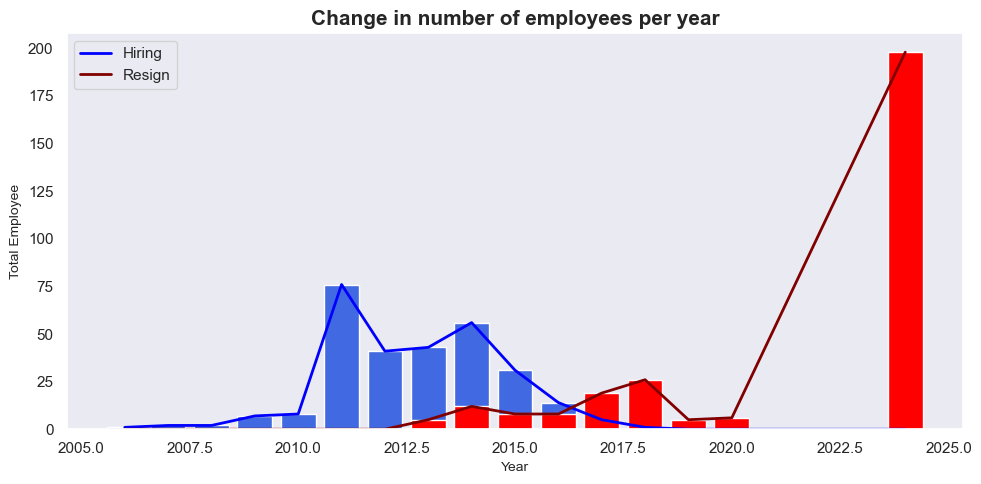

In [553]:
fig,ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=dfg, x='Tahun', y='Jumlah Karyawan Hiring', label='Hiring', lw=2, ax=ax, color= 'blue')
ax.bar(dfg['Tahun'], dfg['Jumlah Karyawan Hiring'], color='royalblue')
sns.lineplot(data=dfg, x='Tahun', y='Jumlah Karyawan Resign', label='Resign', lw=2, ax=ax, color= 'maroon')
ax.bar(dfg['Tahun'], dfg['Jumlah Karyawan Resign'], color='red')
x_start, x_end = plt.gca().get_xlim()
y_start, y_end = plt.gca().get_ylim()
ax.set_xlabel('Year', fontsize=10)
ax.set_ylabel('Total Employee', fontsize=10)
ax.set_title('Change in number of employees per year', fontsize=15, fontweight='bold')
ax.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Resign Reason Analysis for Employee Attrition Management Strategy

In [554]:
df3 = dfg.copy()
df3

,Tahun,Jumlah Karyawan Hiring,Jumlah Karyawan Resign,Jumlah Karyawan,Jumlah Karyawan Sekarang,Persentase Karyawan Sekarang
0,2006,1.0,0.0,1.0,1.0,100.0
1,2007,2.0,0.0,3.0,3.0,100.0
2,2008,2.0,0.0,5.0,5.0,100.0
3,2009,7.0,0.0,12.0,12.0,100.0
4,2010,8.0,0.0,20.0,20.0,100.0
5,2011,76.0,0.0,96.0,96.0,100.0
6,2012,41.0,0.0,137.0,137.0,100.0
7,2013,43.0,5.0,175.0,170.0,97.1
8,2014,56.0,12.0,224.0,212.0,94.6
9,2015,31.0,8.0,259.0,251.0,96.9


In [555]:
df2['Resign'] = np.where(df['TanggalResign']=='-', 0, 1)

In [556]:
df2['Resign'].value_counts()

0    198
1     89
Name: Resign, dtype: int64

## Employee Hire Position

In [557]:
dfh = df2.query('Resign==0').groupby('Pekerjaan')['EnterpriseID'].count().reset_index()
dfh.columns=(['Pekerjaan','Karyawan Bertahan'])
dfh

,Pekerjaan,Karyawan Bertahan
0,Data Analyst,8
1,Data Engineer,7
2,DevOps Engineer,3
3,Digital Product Manager,2
4,Machine Learning Engineer,2
5,Product Design (UI & UX),15
6,Product Design (UX Researcher),1
7,Product Manager,11
8,Scrum Master,3
9,Software Architect,1


## Employee Resign Position

In [558]:
dfr = df2[df2['Resign'] == 1].groupby('Pekerjaan').agg({'Resign' : 'count'}).reset_index()
dfr.rename(columns={'Resign' : 'Karyawan Resign'}, inplace=True)
dfr

,Pekerjaan,Karyawan Resign
0,Data Analyst,8
1,Data Engineer,3
2,Product Design (UI & UX),9
3,Product Manager,6
4,Software Engineer (Android),7
5,Software Engineer (Back End),28
6,Software Engineer (Front End),28


## Merge Data

In [559]:
dfr2 = dfh.merge(dfr, on='Pekerjaan', how='outer').fillna(0)
dfr2['Karyawan Resign'] = dfr2['Karyawan Resign'].astype(int)
dfr2

,Pekerjaan,Karyawan Bertahan,Karyawan Resign
0,Data Analyst,8,8
1,Data Engineer,7,3
2,DevOps Engineer,3,0
3,Digital Product Manager,2,0
4,Machine Learning Engineer,2,0
5,Product Design (UI & UX),15,9
6,Product Design (UX Researcher),1,0
7,Product Manager,11,6
8,Scrum Master,3,0
9,Software Architect,1,0


In [560]:
dfr2['Jumlah Karyawan'] = dfr2['Karyawan Bertahan'] + dfr2['Karyawan Resign'] 
dfr2['Persentase'] = round(dfr2['Karyawan Bertahan'] / dfr2['Jumlah Karyawan'] * 100, 2)
dfr2.sort_values(by='Persentase')

,Pekerjaan,Karyawan Bertahan,Karyawan Resign,Jumlah Karyawan,Persentase
0,Data Analyst,8,8,16,50.00
12,Software Engineer (Front End),44,28,72,61.11
5,Product Design (UI & UX),15,9,24,62.50
7,Product Manager,11,6,17,64.71
1,Data Engineer,7,3,10,70.00
10,Software Engineer (Android),17,7,24,70.83
11,Software Engineer (Back End),81,28,109,74.31
2,DevOps Engineer,3,0,3,100.00
3,Digital Product Manager,2,0,2,100.00
4,Machine Learning Engineer,2,0,2,100.00


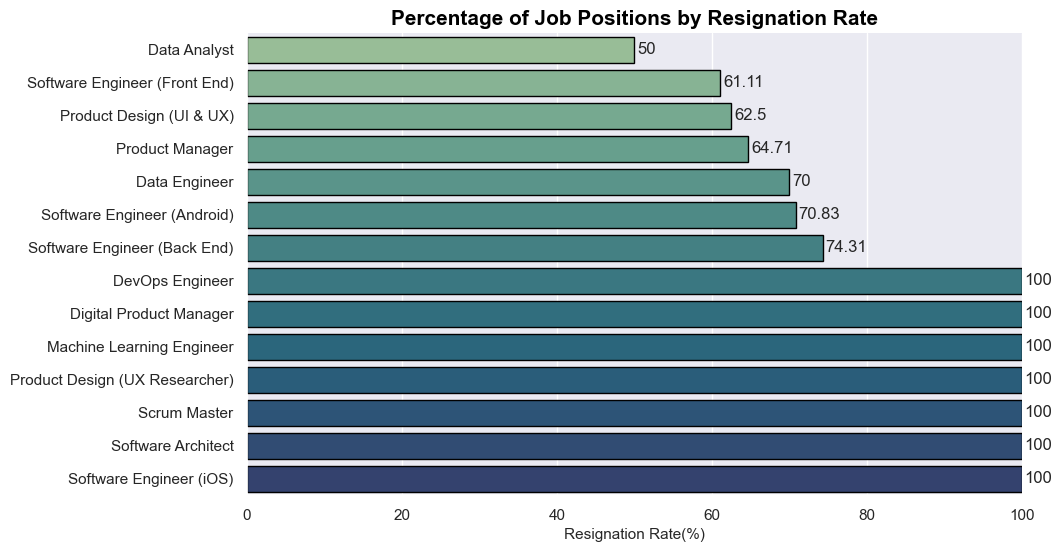

In [561]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Percentage of Job Positions by Resignation Rate", fontsize=15, color='black', weight='bold')
sns.barplot(x='Persentase', y='Pekerjaan', data=dfr2.sort_values(by='Persentase'), edgecolor='black', palette='crest',  orient='h')
plt.xlabel('Resignation Rate(%)', fontsize=11)
plt.xlim(0, 100)
ax.set(ylabel=None)
plt.bar_label(ax.containers[0], padding=2)
sns.despine()
plt.show()

In [562]:
dfr3 = df2[(df2['Resign'] == 1) & (df2['Pekerjaan'] == 'Data Analyst')].groupby(['JenjangKarir', 'PerformancePegawai', 'AlasanResign']).agg({'Resign' : 'count'}).reset_index()
dfr3

,JenjangKarir,PerformancePegawai,AlasanResign,Resign
0,Freshgraduate_program,Bagus,toxic_culture,1
1,Freshgraduate_program,Biasa,internal_conflict,1
2,Freshgraduate_program,Biasa,toxic_culture,1
3,Freshgraduate_program,Sangat_bagus,internal_conflict,1
4,Freshgraduate_program,Sangat_bagus,toxic_culture,3
5,Freshgraduate_program,Sangat_kurang,toxic_culture,1


C:\Users\Win10pro\AppData\Local\Temp\ipykernel_16192\2267796201.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfp = dfr3.groupby('PerformancePegawai').sum().reset_index()


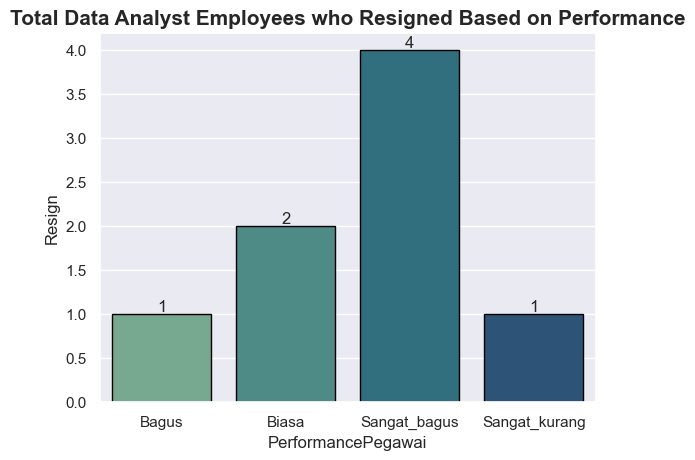

In [563]:
dfp = dfr3.groupby('PerformancePegawai').sum().reset_index()
ax = sns.set_theme(style='darkgrid')
ax = sns.barplot(data=dfp, x='PerformancePegawai', y='Resign', palette = 'crest', edgecolor='black')
plt.title('Total Data Analyst Employees who Resigned Based on Performance', size=15, weight='bold')
ax.bar_label(ax.containers[0])
plt.show()

C:\Users\Win10pro\AppData\Local\Temp\ipykernel_16192\1171676460.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfa = dfr3.groupby('AlasanResign').sum().reset_index()


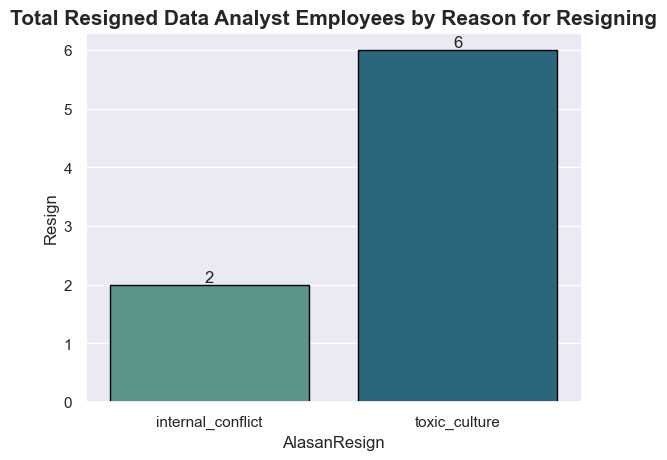

In [564]:
dfa = dfr3.groupby('AlasanResign').sum().reset_index()
ax = sns.set_theme(style='darkgrid')
ax = sns.barplot(data=dfa, x='AlasanResign', y='Resign', palette = 'crest', edgecolor='black')
plt.title('Total Resigned Data Analyst Employees by Reason for Resigning', size=15, weight='bold')
ax.bar_label(ax.containers[0])
plt.show()

## Build an Automated Resignation Behavior Prediction using Machine Learning

In [565]:
df4 = df2.copy()

### Feature Engineering

In [566]:
df4['LamaBekerja'] = df4['TanggalResign'].dt.year - df4['TanggalHiring'].dt.year
df4['LamaBekerja'] = df4['LamaBekerja'].map(lambda x: 0 if x < 0 else x)

In [567]:
df4['UsiaHiring'] = df4['TahunHiring'] - df4['TanggalLahir'].dt.year

In [568]:
df4['Resign']=df4['Resign'].astype('int64')

In [569]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 27 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Username                            287 non-null    object        
 1   EnterpriseID                        287 non-null    int64         
 2   StatusPernikahan                    287 non-null    object        
 3   JenisKelamin                        287 non-null    object        
 4   StatusKepegawaian                   287 non-null    object        
 5   Pekerjaan                           287 non-null    object        
 6   JenjangKarir                        287 non-null    object        
 7   PerformancePegawai                  287 non-null    object        
 8   AsalDaerah                          287 non-null    object        
 9   HiringPlatform                      287 non-null    object        
 10  SkorSurveyEngagement      

### Feature Selection

In [570]:
df_drop = ['JenisKelamin', 'AlasanResign','TanggalHiring', 'TanggalLahir', 'TanggalPenilaianKaryawan','TahunResign', 'TanggalResign', 'TahunHiring']                
dfd = df4.drop(df_drop,axis=1).copy()
dfd.sample(5)

,Username,EnterpriseID,StatusPernikahan,StatusKepegawaian,Pekerjaan,JenjangKarir,PerformancePegawai,AsalDaerah,HiringPlatform,SkorSurveyEngagement,SkorKepuasanPegawai,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,TingkatPendidikan,PernahBekerja,Resign,LamaBekerja,UsiaHiring
94,joyfulBuzzard8,106638,Menikah,FullTime,Software Engineer (Android),Senior_level,Bagus,Jakarta Barat,Google_Search,4,5.0,0.0,0.0,10.0,Magister,1,1,0,33
169,guiltyCardinal3,110461,Belum_menikah,FullTime,Software Engineer (Back End),Mid_level,Kurang,Jakarta Barat,Indeed,5,4.0,6.0,0.0,3.0,Sarjana,1,0,11,26
170,annoyedWhiting8,111276,Lainnya,FullTime,Product Design (UI & UX),Mid_level,Biasa,Jakarta Timur,LinkedIn,4,5.0,0.0,0.0,11.0,Magister,1,0,10,37
113,eagerHoopoe7,111290,Lainnya,FullTime,Product Design (UI & UX),Freshgraduate_program,Biasa,Jakarta Utara,Indeed,4,5.0,0.0,0.0,2.0,Sarjana,1,0,11,24
164,gutturalDotterel4,110703,Belum_menikah,Outsource,Software Engineer (Back End),Senior_level,Biasa,Jakarta Barat,Google_Search,1,3.0,0.0,5.0,19.0,Sarjana,1,0,10,25


### Handling Outlier

In [571]:
cols = dfd.columns
cols

Index(['Username', 'EnterpriseID', 'StatusPernikahan', 'StatusKepegawaian',
       'Pekerjaan', 'JenjangKarir', 'PerformancePegawai', 'AsalDaerah',
       'HiringPlatform', 'SkorSurveyEngagement', 'SkorKepuasanPegawai',
       'JumlahKeikutsertaanProjek', 'JumlahKeterlambatanSebulanTerakhir',
       'JumlahKetidakhadiran', 'TingkatPendidikan', 'PernahBekerja', 'Resign',
       'LamaBekerja', 'UsiaHiring'],
      dtype='object')

In [572]:
nums = []
cats = []

for i in dfd :
  if dfd[i].dtype in ['int64','float64'] :
    nums.append(i)
  else :
    cats.append(i)

print(nums)
print(cats)

['EnterpriseID', 'SkorSurveyEngagement', 'SkorKepuasanPegawai', 'JumlahKeikutsertaanProjek', 'JumlahKeterlambatanSebulanTerakhir', 'JumlahKetidakhadiran', 'PernahBekerja', 'Resign', 'LamaBekerja', 'UsiaHiring']
['Username', 'StatusPernikahan', 'StatusKepegawaian', 'Pekerjaan', 'JenjangKarir', 'PerformancePegawai', 'AsalDaerah', 'HiringPlatform', 'TingkatPendidikan']


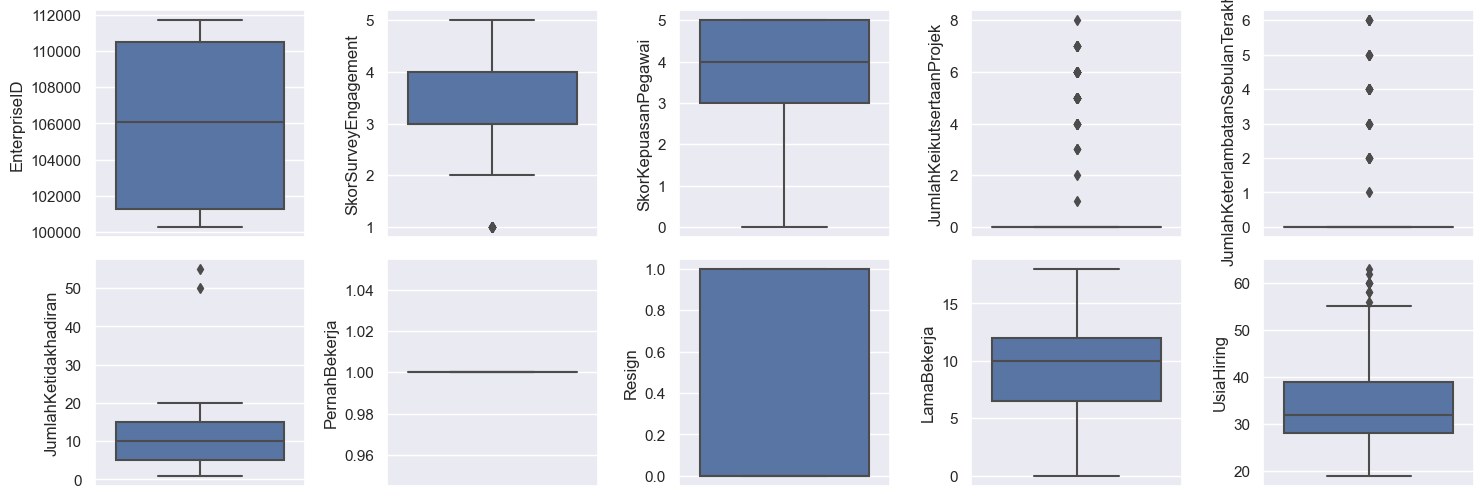

In [573]:
plt.figure(figsize=(15, 30))
for i in range(0, len(nums)):
    plt.subplot(12, 5, i+1)
    sns.boxplot(y=dfd[nums[i]])
    plt.tight_layout()

In [574]:
dfd[nums].describe()

,EnterpriseID,SkorSurveyEngagement,SkorKepuasanPegawai,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,PernahBekerja,Resign,LamaBekerja,UsiaHiring
count,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.0,287.000000,287.000000,287.000000
mean,105923.324042,3.101045,3.836237,1.167247,0.411150,10.439024,1.0,0.310105,9.066202,34.080139
std,4044.977599,0.836388,1.039942,2.285537,1.273018,6.829769,0.0,0.463344,4.002509,8.854922
min,100282.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.0,0.000000,0.000000,19.000000
25%,101269.000000,3.000000,3.000000,0.000000,0.000000,5.000000,1.0,0.000000,6.500000,28.000000
50%,106069.000000,3.000000,4.000000,0.000000,0.000000,10.000000,1.0,0.000000,10.000000,32.000000
75%,110514.500000,4.000000,5.000000,0.000000,0.000000,15.000000,1.0,1.000000,12.000000,39.000000
max,111703.000000,5.000000,5.000000,8.000000,6.000000,55.000000,1.0,1.000000,18.000000,63.000000


In [575]:
nums2 = ['EnterpriseID', 'JumlahKetidakhadiran','LamaBekerja','UsiaHiring','SkorKepuasanPegawai']

In [576]:
print(f'Total Rows BEFORE Outlier Handling Z-Score = {len(dfd)}')
filtered_entries = np.array([True] * len(dfd))
for col in nums2:
    zscore = abs(stats.zscore(dfd[col]))
    filtered_entries = (zscore < 3) & filtered_entries 
dfd = dfd[filtered_entries] 
print(f'Total Rows AFTER Outlier Handling Z-Score = {len(dfd)}')

Total Rows BEFORE Outlier Handling Z-Score = 287
Total Rows AFTER Outlier Handling Z-Score = 278


In [577]:
dfd.duplicated().any()

False

### Feature Encoding

In [578]:
dfd.head()

,Username,EnterpriseID,StatusPernikahan,StatusKepegawaian,Pekerjaan,JenjangKarir,PerformancePegawai,AsalDaerah,HiringPlatform,SkorSurveyEngagement,SkorKepuasanPegawai,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,TingkatPendidikan,PernahBekerja,Resign,LamaBekerja,UsiaHiring
0,spiritedPorpoise3,111065,Belum_menikah,Outsource,Software Engineer (Back End),Freshgraduate_program,Sangat_bagus,Jakarta Timur,Employee_Referral,4,4.0,0.0,0.0,9.0,Magister,1,0,13,39
1,jealousGelding2,106080,Belum_menikah,FullTime,Data Analyst,Freshgraduate_program,Sangat_kurang,Jakarta Utara,Website,4,4.0,4.0,0.0,3.0,Sarjana,1,1,4,30
2,pluckyMuesli3,106452,Menikah,FullTime,Software Engineer (Front End),Freshgraduate_program,Bagus,Jakarta Timur,Indeed,4,3.0,0.0,0.0,11.0,Magister,1,1,3,37
3,stressedTruffle1,106325,Belum_menikah,Outsource,Software Engineer (Front End),Freshgraduate_program,Bagus,Jakarta Pusat,LinkedIn,3,3.0,0.0,4.0,6.0,Sarjana,1,0,10,35
4,shyTermite7,111171,Belum_menikah,FullTime,Product Manager,Freshgraduate_program,Bagus,Jakarta Timur,LinkedIn,3,3.0,0.0,0.0,11.0,Sarjana,1,1,5,39


In [579]:
dfd["StatusPernikahan"] = dfd["StatusPernikahan"].map(lambda x: "Lainnya" if x == "-" else x)
dfd["AsalDaerah"] = dfd["AsalDaerah"].map(lambda x: x.replace(" ", "_"))

career = {'Freshgraduate_program' : 0,
          'Mid_level' : 1,
          'Senior_level' : 2}
dfd['JenjangKarir'] = dfd['JenjangKarir'].map(career)

edu = {'Sarjana' : 0,
       'Magister' : 1,
       'Doktor' : 2}
dfd['TingkatPendidikan'] = dfd['TingkatPendidikan'].map(edu)

performance = {'Sangat_kurang' : 0,
               'Kurang' : 1,
               'Biasa' : 2,
               'Bagus' : 3,
               'Sangat_bagus' : 4}
dfd['PerformancePegawai'] = dfd['PerformancePegawai'].map(performance)

engineering_div = ['Software Engineer (Back End)',
               'Software Engineer (Front End)',
               'Software Engineer (Android)',
               'Software Engineer (iOS)', 
               'DevOps Engineer', 
               'Software Architect', 
               'Machine Learning Engineer']
data_div = ['Data Analyst', 'Data Engineer']
product_div = ['Product Manager', 
               'Product Design (UX Researcher)', 
               'Product Design (UI & UX)', 
               'Digital Product Manager',
               'Scrum Master']

dfd['Pekerjaan'] = dfd['Pekerjaan'].map(lambda x: 'engineering_division' if x in engineering_div else \
                                                       'data_division' if x in data_div else 'product_division')

frequency_logic = dfd.groupby('HiringPlatform').size()/len(dfd)
dfd['HiringPlatform_Encode'] = dfd['HiringPlatform'].map(frequency_logic)
dfd.drop(['HiringPlatform'],axis=1,inplace=True)

In [580]:
df_cat = dfd.select_dtypes(include = ['object'])
df_num = dfd.select_dtypes(include = ['int64', 'float64'])

In [581]:
df_cat.describe()

,Username,StatusPernikahan,StatusKepegawaian,Pekerjaan,AsalDaerah
count,278,278,278,278,278
unique,276,4,3,3,5
top,brainyMagpie7,Belum_menikah,FullTime,engineering_division,Jakarta_Pusat
freq,2,133,209,207,68


In [582]:
df_num.describe()

,EnterpriseID,JenjangKarir,PerformancePegawai,SkorSurveyEngagement,SkorKepuasanPegawai,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,TingkatPendidikan,PernahBekerja,Resign,LamaBekerja,UsiaHiring,HiringPlatform_Encode
count,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.0,278.00000,278.000000,278.000000,278.000000
mean,105907.435252,0.571942,2.507194,3.097122,3.899281,1.154676,0.410072,10.093525,0.467626,1.0,0.31295,9.068345,33.856115,0.195073
std,4035.802417,0.760157,1.218814,0.837690,0.913556,2.259636,1.273518,5.895470,0.650489,0.0,0.46453,4.008881,8.595659,0.092675
min,100282.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,0.00000,0.000000,19.000000,0.003597
25%,101282.000000,0.000000,2.000000,3.000000,3.000000,0.000000,0.000000,4.250000,0.000000,1.0,0.00000,6.250000,28.000000,0.093525
50%,106051.500000,0.000000,3.000000,3.000000,4.000000,0.000000,0.000000,10.000000,0.000000,1.0,0.00000,10.000000,32.000000,0.237410
75%,110519.250000,1.000000,4.000000,4.000000,5.000000,0.000000,0.000000,15.000000,1.000000,1.0,1.00000,12.000000,39.000000,0.302158
max,111703.000000,2.000000,4.000000,5.000000,5.000000,7.000000,6.000000,20.000000,2.000000,1.0,1.00000,18.000000,60.000000,0.302158


In [583]:
df_cat = pd.get_dummies(df_cat)
df_cat.head()

,Username_abjectRuffs3,Username_aboardUnicorn8,Username_adoringCardinal9,Username_adoringMacaw3,Username_affectedLemur7,Username_affectedLollies9,Username_affectedPup0,Username_alertDoughnut7,Username_alertSyrup3,Username_aloofBasmati5,...,StatusKepegawaian_Internship,StatusKepegawaian_Outsource,Pekerjaan_data_division,Pekerjaan_engineering_division,Pekerjaan_product_division,AsalDaerah_Jakarta_Barat,AsalDaerah_Jakarta_Pusat,AsalDaerah_Jakarta_Selatan,AsalDaerah_Jakarta_Timur,AsalDaerah_Jakarta_Utara
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [584]:
dfdr = pd.concat([df_num,df_cat],axis=1).set_index(['EnterpriseID'])
dfdr.head()

,JenjangKarir,PerformancePegawai,SkorSurveyEngagement,SkorKepuasanPegawai,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,TingkatPendidikan,PernahBekerja,Resign,...,StatusKepegawaian_Internship,StatusKepegawaian_Outsource,Pekerjaan_data_division,Pekerjaan_engineering_division,Pekerjaan_product_division,AsalDaerah_Jakarta_Barat,AsalDaerah_Jakarta_Pusat,AsalDaerah_Jakarta_Selatan,AsalDaerah_Jakarta_Timur,AsalDaerah_Jakarta_Utara
EnterpriseID,,,,,,,,,,,,,,,,,,,,,
111065,0,4,4,4.0,0.0,0.0,9.0,1,1,0,...,0,1,0,1,0,0,0,0,1,0
106080,0,0,4,4.0,4.0,0.0,3.0,0,1,1,...,0,0,1,0,0,0,0,0,0,1
106452,0,3,4,3.0,0.0,0.0,11.0,1,1,1,...,0,0,0,1,0,0,0,0,1,0
106325,0,3,3,3.0,0.0,4.0,6.0,0,1,0,...,0,1,0,1,0,0,1,0,0,0
111171,0,3,3,3.0,0.0,0.0,11.0,0,1,1,...,0,0,0,0,1,0,0,0,1,0


In [585]:
dfdr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278 entries, 111065 to 106214
Columns: 304 entries, JenjangKarir to AsalDaerah_Jakarta_Utara
dtypes: float64(5), int64(8), uint8(291)
memory usage: 109.4 KB


### Handling Class Imbalance

In [586]:
dfdr['Resign'].value_counts()

0    191
1     87
Name: Resign, dtype: int64

In [587]:
100.00 * dfdr['Resign'].value_counts() / dfdr['Resign'].shape[0]

0    68.705036
1    31.294964
Name: Resign, dtype: float64

In [588]:
X = dfdr.drop(columns=['Resign'])
y = dfdr['Resign']

### Split Data

In [589]:
print(X.shape)
print(y.shape)

(278, 303)
(278,)


In [590]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [591]:
print('X_train size : ', X_train.shape)
print('X_test size  : ', X_test.shape)
print('y_train size : ', y_train.shape)
print('y_test size  : ', y_test.shape)

X_train size :  (222, 303)
X_test size  :  (56, 303)
y_train size :  (222,)
y_test size  :  (56,)


In [592]:
dfdr.isna().sum()

JenjangKarir                  0
PerformancePegawai            0
SkorSurveyEngagement          0
SkorKepuasanPegawai           0
JumlahKeikutsertaanProjek     0
                             ..
AsalDaerah_Jakarta_Barat      0
AsalDaerah_Jakarta_Pusat      0
AsalDaerah_Jakarta_Selatan    0
AsalDaerah_Jakarta_Timur      0
AsalDaerah_Jakarta_Utara      0
Length: 304, dtype: int64

In [593]:
X_train_over, y_train_over = SMOTE().fit_resample(X_train, y_train)

In [594]:
print('Target BEFORE oversampling:')
print(pd.Series(y_train).value_counts())

Target BEFORE oversampling:
0    155
1     67
Name: Resign, dtype: int64


In [595]:
print('Target AFTER oversampling:')
print(pd.Series(y_train_over).value_counts())

Target AFTER oversampling:
0    155
1    155
Name: Resign, dtype: int64


In [596]:
tl = TomekLinks(sampling_strategy="auto")
rus = RandomUnderSampler(random_state=42)
enn = EditedNearestNeighbours()
senn = SMOTEENN(random_state=123)
stl = SMOTETomek(random_state=42)

In [597]:
list_all_imbalanced = [tl,rus,enn,senn,stl]

imbalance_strategy = []
score_accuracy = []
score_precision = []
score_recall = []
score_auc = []
time_training = []

for imbalanced_learning in list_all_imbalanced:
    print(f"Processing {imbalanced_learning.__class__.__name__}")
    start_time = time.time()
    model = XGBClassifier(verbosity = 0,use_label_encoder = False, random_state = 123)
    pipeline=Pipeline(steps=[("r", imbalanced_learning), ("m", model)])
    
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    scoring=["accuracy","precision_macro","recall_macro","roc_auc"]
    scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    
    imbalance_strategy.append(imbalanced_learning.__class__.__name__)
    score_accuracy.append(np.mean(scores["test_accuracy"]))
    score_precision.append(np.mean(scores["test_precision_macro"]))
    score_recall.append(np.mean(scores["test_recall_macro"]))
    score_auc.append(np.mean(scores["test_roc_auc"]))
    end_time = time.time()
    time_training.append(time.strftime('%H:%M:%S', time.gmtime(end_time - start_time)))
    
df_evaluation = pd.DataFrame({"Imbalance_Strategy":imbalance_strategy,
                              "Accuracy": score_accuracy,
                              "Precision": score_precision,
                              "Recall": score_recall,
                              "AUC": score_auc,
                              "Training_Time": time_training})
df_evaluation.sort_values(["AUC"],ascending=False)

Processing TomekLinks
Processing RandomUnderSampler
Processing EditedNearestNeighbours
Processing SMOTEENN
Processing SMOTETomek


,Imbalance_Strategy,Accuracy,Precision,Recall,AUC,Training_Time
4,SMOTETomek,0.974506,0.970576,0.972173,0.995794,00:00:21
2,EditedNearestNeighbours,0.964032,0.957118,0.965000,0.995139,00:00:14
0,TomekLinks,0.974506,0.970159,0.973512,0.994454,00:00:30
3,SMOTEENN,0.956653,0.951373,0.953968,0.992842,00:00:17
1,RandomUnderSampler,0.971476,0.962955,0.974296,0.992530,00:00:13


### Modelling

In [598]:
m1 = RandomForestClassifier(random_state=0)
m2 = LogisticRegression()
m3 = DecisionTreeClassifier(random_state=0)
m4 = AdaBoostClassifier(random_state=0,base_estimator=m3)
m5 = KNeighborsClassifier()
m6 = XGBClassifier(random_state=0)
m7 = CatBoostClassifier(random_state=0)

classifier_list = [m1,m2,m3,m4,m5,m6,m7]

In [599]:
ml_model = []
score_accuracy = []
score_precision = []
score_recall = []
score_auc = []
time_training = []

for model in classifier_list:
    print(f"Processing {model.__class__.__name__}")
    
    start_time = time.time()

    pipeline=Pipeline(steps=[("r", SMOTE()), ("m", model)])
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    scoring=["accuracy","precision_macro","recall_macro","roc_auc"]
    
    scores = cross_validate(pipeline, 
                            X_train, 
                            y_train, 
                            scoring = scoring, 
                            cv = cv, 
                            n_jobs = -1)
    
    ml_model.append(model.__class__.__name__)
    score_accuracy.append(np.mean(scores["test_accuracy"]))
    score_precision.append(np.mean(scores["test_precision_macro"]))
    score_recall.append(np.mean(scores["test_recall_macro"]))
    score_auc.append(np.mean(scores["test_roc_auc"]))
    end_time = time.time()
    time_training.append(time.strftime('%H:%M:%S', time.gmtime(end_time - start_time)))
    
df_model = pd.DataFrame({"ML_Model":ml_model,
                         "Accuracy": score_accuracy,
                         "Precision": score_precision,
                         "Recall": score_recall,
                         "AUC": score_auc,
                         "Training_Time": time_training})
df_model.sort_values(["AUC"],ascending=False)

Processing RandomForestClassifier
Processing LogisticRegression
Processing DecisionTreeClassifier
Processing AdaBoostClassifier
Processing KNeighborsClassifier
Processing XGBClassifier
Processing CatBoostClassifier


,ML_Model,Accuracy,Precision,Recall,AUC,Training_Time
5,XGBClassifier,0.974572,0.970776,0.972242,0.996766,00:00:17
1,LogisticRegression,0.962451,0.959549,0.953810,0.995754,00:00:07
6,CatBoostClassifier,0.955072,0.948306,0.952996,0.994514,00:02:41
0,RandomForestClassifier,0.931028,0.940538,0.902004,0.983353,00:00:14
4,KNeighborsClassifier,0.933992,0.922482,0.931726,0.980937,00:00:09
3,AdaBoostClassifier,0.961199,0.956090,0.955238,0.955238,00:00:06
2,DecisionTreeClassifier,0.955007,0.949771,0.947857,0.947857,00:00:05


In [626]:
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'n_estimators': hp.quniform('n_estimators',100,500,20),
    "max_depth" : hp.quniform('max_depth', 3, 10, 1)
}

def rskf_metrics(model, X, y, scoring_used = "precision", cv_method = "", nfolds = 10):
    if cv_method == "":
        cv_method = RepeatedStratifiedKFold(n_splits=nfolds, n_repeats=3, random_state=1)
        
    metrics_calculation= cross_val_score(model, X, y, scoring=scoring_used, cv = cv_method)
    
    return(metrics_calculation)

def objective(params,
              n_folds=10,
              X=X_train_over, 
              y=y_train_over, 
              scoring_used="precision",
              cv_used=""):

    global ITERATION
    ITERATION += 1
    
    start = timer()
    
    model_hyper = XGBClassifier(random_state = 123,verbose=0, **params)
    
    run_time = timer() - start
    
    metrics_used = np.mean(rskf_metrics(model_hyper, X, y))
    
    return {'loss': metrics_used, 'params': params, 'iteration': ITERATION, 
            'train_time': run_time, 'status': STATUS_OK}

In [609]:
%%time

global  ITERATION

ITERATION = 0

tpe_algorithm = tpe.suggest

trials = Trials()

best_classifier = fmin(objective, space, algo=tpe_algorithm, max_evals=42, trials=trials)

100%|██████████| 42/42 [43:51<00:00, 62.66s/trial, best loss: 0.9483951914098974] 
CPU times: total: 1h 33min 55s
Wall time: 43min 51s


In [628]:
best_params = space_eval(space, best_classifier)
best_params

{'learning_rate': 0.06889620197523828, 'max_depth': 3.0, 'n_estimators': 360.0}

In [656]:
xgboost_model = XGBClassifier(objective='binary:logistic')
xgboost_model.fit(X_train, y_train)

y_pred = xgboost_model.predict(X_test)
y_pred_proba = xgboost_model.predict_proba(X_test)[:,1]

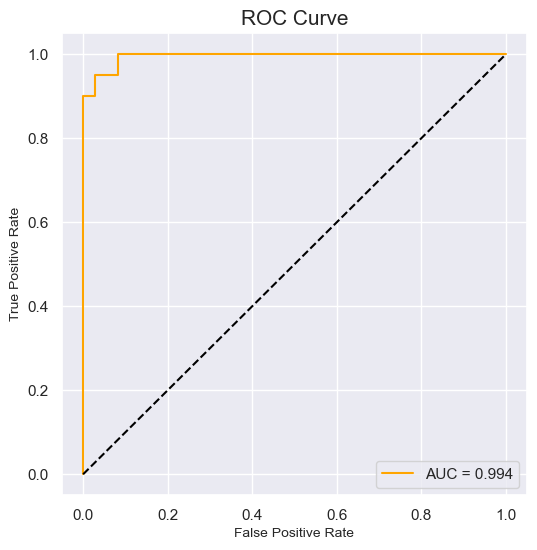

In [657]:
fpr, tpr, tr = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='AUC = %0.3f' %auc, color='orange')
plt.plot(fpr, fpr, linestyle = '--', color='black')
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate', fontsize=10)
plt.title('ROC Curve', fontsize=15)
plt.legend()
plt.show()

In [658]:
y_pred_class = []

for i in y_pred_proba:
    if i > 0.5:
        y_pred_class.append(1)
    else:
        y_pred_class.append(0)

print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96        36
           1       0.95      0.90      0.92        20

    accuracy                           0.95        56
   macro avg       0.95      0.94      0.94        56
weighted avg       0.95      0.95      0.95        56



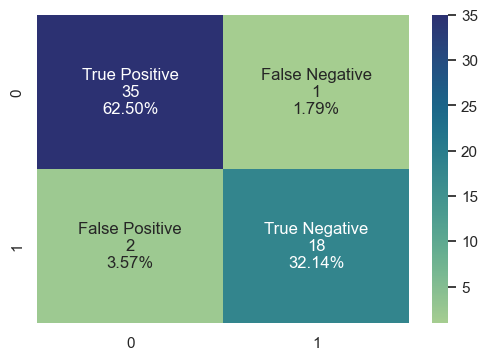

In [659]:
cf_matrix = confusion_matrix(y_test, y_pred_class)

group_names = ["True Positive", "False Negative", "False Positive", "True Negative"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_pcts = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_pcts)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(6, 4))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='crest')
plt.show()

# Presenting Machine Learning Products to the Business Users

[23:19:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


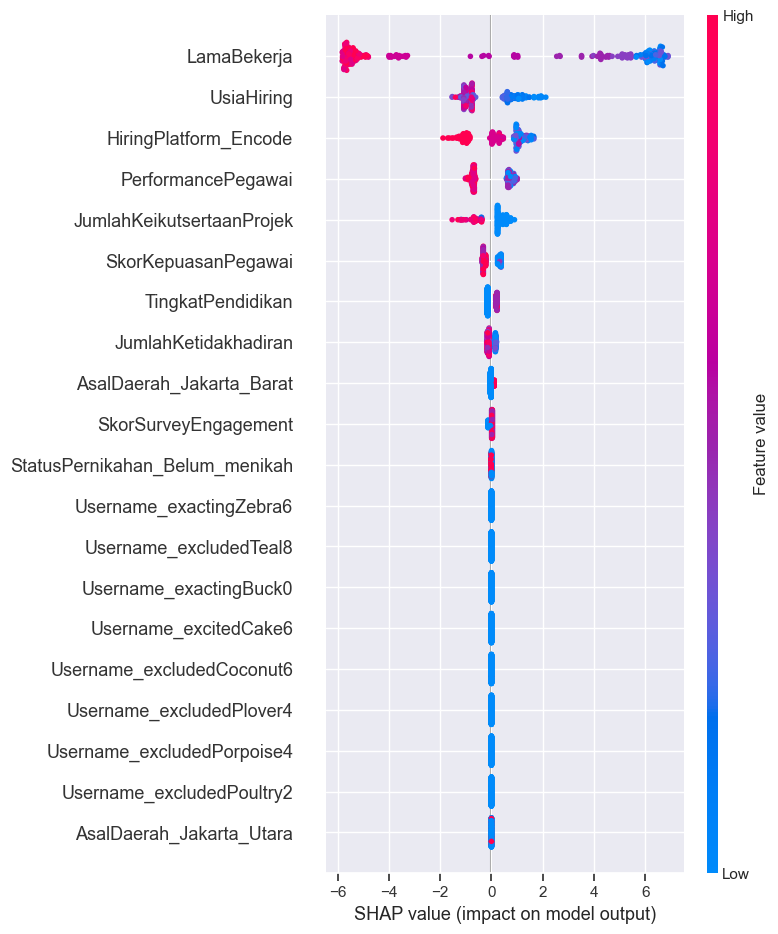

In [662]:
import shap
explainer = shap.TreeExplainer(xgboost_model)
shap_values = explainer.shap_values(X_train_over)
shap.summary_plot(shap_values, X_train_over, plot_type='dot')

[23:25:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


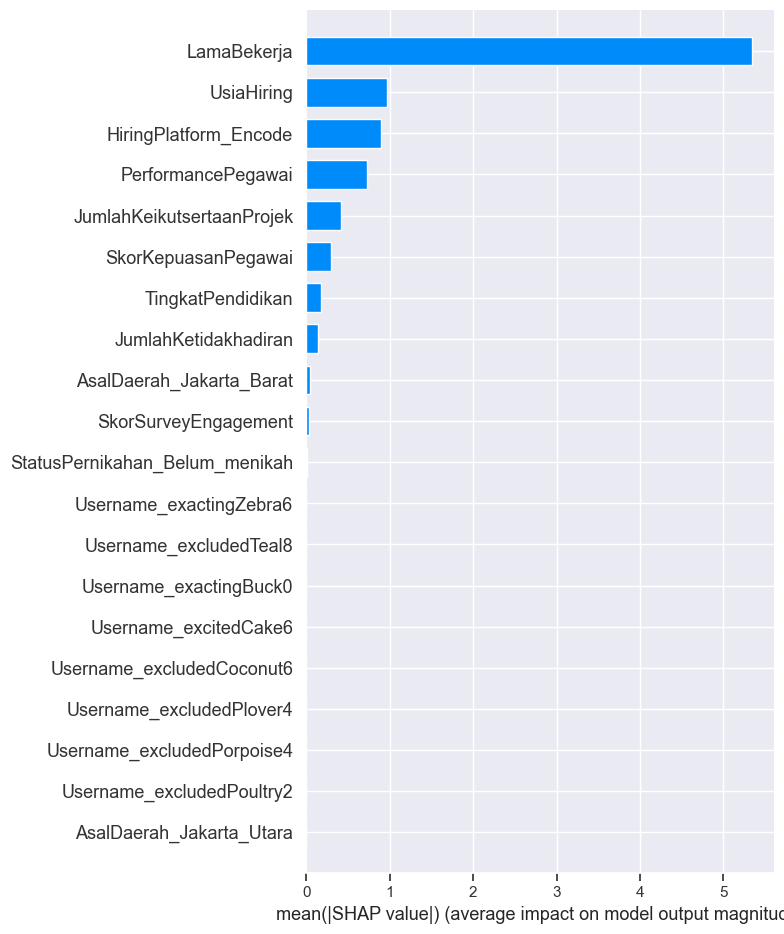

In [666]:
x_sampled = X_train.sample(100, random_state=10)
explainer = shap.TreeExplainer(xgboost_model)
shap_values = explainer.shap_values(x_sampled)
shap.summary_plot(shap_values, x_sampled, plot_type="bar")

In [663]:
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(5).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('Scale of Variable Importance')
    plt.ylabel('Variable Names')
    plt.title('Most Importance Variables based on Machine Learning')

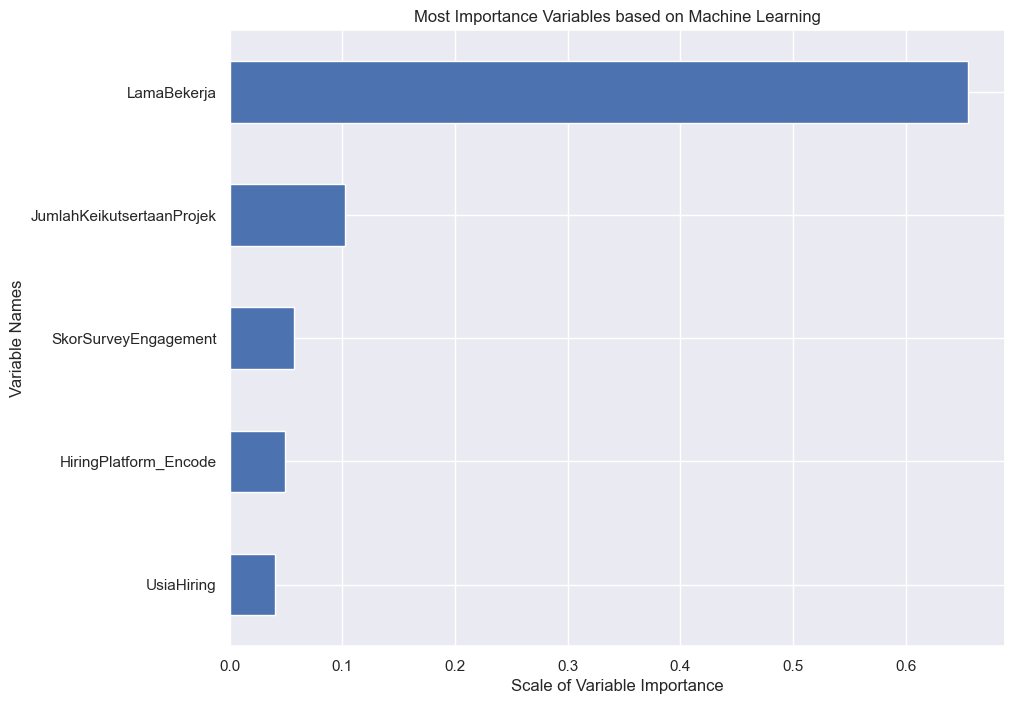

In [664]:
show_feature_importance(xgboost_model)